### 종관기상데이터 전처리를 위한 notebook

종관기상관측 데이터란: 종관기상관측이란 종관규모의 날씨를 파악하기 위하여 정해진 시각에 모든 관측소에서 같은 시각에 실시하는 지상관측.
- 종관규모: 일기도에 표현되어 있는 보통의 고기압이나 저기압의 공간적 크기 및 수명을 말하며, 주로 매일의 날씨 현상을 뜻함.

|기간|위치|제공 요소|비고|지도상 거리|
|:-|:-|:-|:-|:-|
|2018.01.01 ~ 2021.12.31|[기상청 종관기상관측 데이터 중 서울특별시: 관악산, 서울](https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36)|기온, 강수, 바람, 기압, 습도, 일사, 일조, 눈, 구름, 시정, 지면상태, 지면 · 초상온도, 일기현상, 증발량, 현상번호|10분 또는 1시간 최다강수시각은 최다강수가 나타난 시작 시간으로, (-) 표기가 있는 경우 전날을 뜻함|![종관기상관측/기상청위치](https://user-images.githubusercontent.com/60145951/153731135-1b43357d-a05b-4bd2-ab20-bb4f3c7eaa6c.png)|


|측정|기온|강수|풍속|습도|기압|일조일사|눈|구름|지면초상온도|기타|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|'지점', '지점명', '일시'|'기온(°C)', '기온 QC플래그'|'강수량(mm)', '강수량 QC플래그'|'풍속(m/s)', '풍속 QC플래그', '풍향(16방위)', '풍향 QC플래그'|'습도(%)', '습도 QC플래그'|'증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)', '현지기압 QC플래그', '해면기압(hPa)', '해면기압 QC플래그'|'일조(hr)', '일조 QC플래그', '일사(MJ/m2)', '일사 QC플래그'|'적설(cm)', '3시간신적설(cm)'|'전운량(10분위)', '중하층운량(10분위)', '운형(운형약어)', '최저운고(100m )'|'시정(10m)', '지면상태(지면상태코드)', '지면온도(°C)', '지면온도 QC플래그', '5cm 지중온도(°C)', '10cm 지중온도(°C)', '20cm 지중온도(°C)', '30cm 지중온도(°C)'| '현상번호(국내식)'|

### load libraries

In [1]:
# basic tools
import os
import glob
import math
import re

# basic tools for ML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Deep Learning
import tensorflow as tf
from sklearn.model_selection import train_test_split

# 과학적 표기법 해제
pd.options.display.float_format = '{:.5f}'.format

### load data

In [2]:
class WeatherASOS:
    def __init__(self, PATH):
        self.USER_PATH = PATH
    
    def load_data(self, PATH:str, parse_cols:list=["일시"], encoding_format:str='cp949') -> pd.DataFrame:
        return pd.read_csv(PATH, parse_dates=parse_cols, encoding=encoding_format)

    # 전체 데이터 연결한 데이터프레임 생성
    def concat_dataframes(self) -> pd.DataFrame:
        PATH = self.USER_PATH
        df=pd.DataFrame()
        file_names = glob.glob(PATH + "**")
        for file_name in file_names:
            df_2 = self.load_data(PATH=file_name)
            df = pd.concat([df,df_2],ignore_index=True)
        return df

In [3]:
seoul_asos = WeatherASOS("../data/ASOS/seoul_day_108/")  # 2018-2021
df_seoul_2018_to_2021 = seoul_asos.concat_dataframes()    # 1461 * 61

In [4]:
df_seoul_2018_to_2021.columns

Index(['지점', '일시', '평균기온(°C)', '최저기온(°C)', '최저기온 시각(hhmi)', '최고기온(°C)',
       '최고기온 시각(hhmi)', '강수 계속시간(hr)', '10분 최다 강수량(mm)', '10분 최다강수량 시각(hhmi)',
       '1시간 최다강수량(mm)', '1시간 최다 강수량 시각(hhmi)', '일강수량(mm)', '최대 순간 풍속(m/s)',
       '최대 순간 풍속 풍향(16방위)', '최대 순간풍속 시각(hhmi)', '최대 풍속(m/s)', '최대 풍속 풍향(16방위)',
       '최대 풍속 시각(hhmi)', '평균 풍속(m/s)', '풍정합(100m)', '평균 이슬점온도(°C)',
       '최소 상대습도(%)', '최소 상대습도 시각(hhmi)', '평균 상대습도(%)', '평균 증기압(hPa)',
       '평균 현지기압(hPa)', '최고 해면기압(hPa)', '최고 해면기압 시각(hhmi)', '최저 해면기압(hPa)',
       '최저 해면기압 시각(hhmi)', '평균 해면기압(hPa)', '가조시간(hr)', '합계 일조시간(hr)',
       '1시간 최다일사 시각(hhmi)', '1시간 최다일사량(MJ/m2)', '합계 일사량(MJ/m2)', '일 최심신적설(cm)',
       '일 최심신적설 시각(hhmi)', '일 최심적설(cm)', '일 최심적설 시각(hhmi)', '합계 3시간 신적설(cm)',
       '평균 전운량(1/10)', '평균 중하층운량(1/10)', '평균 지면온도(°C)', '최저 초상온도(°C)',
       '평균 5cm 지중온도(°C)', '평균 10cm 지중온도(°C)', '평균 20cm 지중온도(°C)',
       '평균 30cm 지중온도(°C)', '0.5m 지중온도(°C)', '1.0m 지중온도(°C)', '1.5m 지중온도(°C)',
       '3.0m 지중온도(°C)', '5.0m 지중온도(°C

살릴 columns 선택: 기온, 강수, 습도, 구름, 지면온도
- 기온: '평균기온(°C)', '최저기온(°C)', '최고기온(°C)'
- 강수: '강수 계속시간(hr)', '일강수량(mm)', '9-9강수(mm)'
- 습도: '평균 이슬점온도(°C)', '최소 상대습도(%)', '최소 상대습도 시각(hhmi)', '평균 상대습도(%)'
<!-- - 일조일사: '합계 일조시간(hr)', '1시간 최다일사 시각(hhmi)', '1시간 최다일사량(MJ/m2)', '합계 일사량(MJ/m2)', '합계 일조 시간(hr)', '합계 일사(MJ/m2)' -->
- 구름: '평균 전운량(1/10)', '평균 중하층운량(1/10)'
- 지면온도: '평균 지면온도(°C)'

In [5]:
from consumption import UserConsumption

User = UserConsumption('../data/private/PowerConsumption/')    # prophet.py 파일 기준으로 상대경로 입력
user_consumption = User.concat_dataframes()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  1461 non-null   datetime64[ns]
 1   전기        1461 non-null   float64       
 2   수도        1461 non-null   float64       
 3   온수        1461 non-null   float64       
 4   가스        1461 non-null   float64       
 5   열량        1461 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 68.6 KB


In [6]:
df_seoul_2018_to_2021['전력사용량'] = user_consumption['전기']

In [7]:
df_seoul_2018_to_2021.corr()[df_seoul_2018_to_2021.corr()['전력사용량']>=0.2]['전력사용량']

# --- 결측치 처리 --- #
# 강수 계속시간, 일강수량 제외 결측치 없음
# 강수량 결측치 0으로 채우고 3개 경우의 수로 나눌 것: 비 오지 않음, 비 보통, 비 많음

# --- 파생변수 --- #
# 최저기온 살리고 평균 증기압 추가
# 불쾌지수로 상대습도 대체
# 1.5m 지중온도 살리고 최저 초상온도 살림: 오래 햇빛을 받을수록 열에너지가 많이 남으니까

평균기온(°C)           0.21844
최저기온(°C)           0.22844
최고기온(°C)           0.20411
평균 이슬점온도(°C)       0.22234
평균 증기압(hPa)        0.25385
평균 지면온도(°C)        0.22174
최저 초상온도(°C)        0.23206
평균 5cm 지중온도(°C)    0.22740
평균 10cm 지중온도(°C)   0.23114
평균 20cm 지중온도(°C)   0.23421
평균 30cm 지중온도(°C)   0.23825
0.5m 지중온도(°C)      0.24058
1.0m 지중온도(°C)      0.24309
1.5m 지중온도(°C)      0.24058
전력사용량              1.00000
Name: 전력사용량, dtype: float64

In [8]:
df_seoul_simple = df_seoul_2018_to_2021[['일시', '평균기온(°C)', '최저기온(°C)', 
                                            '평균 상대습도(%)', '평균 증기압(hPa)', '평균 중하층운량(1/10)', 
                                            '최저 초상온도(°C)', '1.5m 지중온도(°C)']]
df_seoul_simple['전력사용량'] = user_consumption['전기']

/var/folders/rl/45hg875x1rd0tqbt0wx9whm80000gn/T/ipykernel_7402/835967364.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seoul_simple['전력사용량'] = user_consumption['전기']


In [9]:
df_seoul_simple.corr()

,평균기온(°C),최저기온(°C),평균 상대습도(%),평균 증기압(hPa),평균 중하층운량(1/10),최저 초상온도(°C),1.5m 지중온도(°C),전력사용량
평균기온(°C),1.00000,0.98926,0.43835,0.89876,0.22088,0.96679,0.79265,0.21844
최저기온(°C),0.98926,1.00000,0.50404,0.92782,0.29610,0.98654,0.80555,0.22844
평균 상대습도(%),0.43835,0.50404,1.00000,0.65179,0.65975,0.55871,0.45694,0.12969
평균 증기압(hPa),0.89876,0.92782,0.65179,1.00000,0.39298,0.94519,0.79737,0.25385
평균 중하층운량(1/10),0.22088,0.29610,0.65975,0.39298,1.00000,0.36087,0.15555,0.08014
최저 초상온도(°C),0.96679,0.98654,0.55871,0.94519,0.36087,1.00000,0.80972,0.23206
1.5m 지중온도(°C),0.79265,0.80555,0.45694,0.79737,0.15555,0.80972,1.00000,0.24058
전력사용량,0.21844,0.22844,0.12969,0.25385,0.08014,0.23206,0.24058,1.00000


### preprocess

#### 전처리: 불쾌지수로 상대습도 대체

In [10]:
# 불쾌지수 discomfort index
# DI 9/5Ta-0.55(1-RH)(9/5Ta-26)+32
# Ta : 건구온도 (℃)
# RH : 상대습도 (소수단위)
def is_comfort(df:pd.DataFrame, ta_column:str, rh_column:str):    # ta: 기온, rh: 습도
    temp_df = df.copy()
    ta, rh = temp_df[ta_column], temp_df[rh_column]
    discomfort_information = (9/5 * ta) - 0.55 * (1-rh) * ((9/5 * ta) - 26) + 32
    temp_df['불쾌지수'] = discomfort_information
    
    # ~ 20 : 0
    # 20 ~ 25 : 1 # 25 ~ : 2 -> 통합
    temp_df.loc[(temp_df['불쾌지수'] <= 20), '불쾌지수'] = 0
    temp_df.loc[(temp_df['불쾌지수'] > 20), '불쾌지수'] = 1
    
    return temp_df

In [11]:
df_seoul_comfort = is_comfort(df_seoul_simple, ta_column="평균기온(°C)", rh_column="평균 상대습도(%)")

In [12]:
df_seoul_comfort['불쾌지수'].value_counts()

1.00000    739
0.00000    722
Name: 불쾌지수, dtype: int64

### 그 외

하려고 했던 것들
- 체감온도 : 추위와 관계되는데 추위는 전기사용량에 큰 영향을 미치지 않는듯함
- 강수량 결측치 채운 후 바인딩 : 강수량과 전력 사용량의 상관관계가 0.1이 되지 않음
- 구름 많음, 적음 정도 : 대신 지중온도를 사용 (상관관계가 더 크기도 함)

In [13]:
df_seoul_comfort.corr()
# 불쾌지수가 1.69로 상대습도 1.29보다는 그나마 높은 상관계수 보임

,평균기온(°C),최저기온(°C),평균 상대습도(%),평균 증기압(hPa),평균 중하층운량(1/10),최저 초상온도(°C),1.5m 지중온도(°C),전력사용량,불쾌지수
평균기온(°C),1.00000,0.98926,0.43835,0.89876,0.22088,0.96679,0.79265,0.21844,0.85557
최저기온(°C),0.98926,1.00000,0.50404,0.92782,0.29610,0.98654,0.80555,0.22844,0.85093
평균 상대습도(%),0.43835,0.50404,1.00000,0.65179,0.65975,0.55871,0.45694,0.12969,0.35979
평균 증기압(hPa),0.89876,0.92782,0.65179,1.00000,0.39298,0.94519,0.79737,0.25385,0.79408
평균 중하층운량(1/10),0.22088,0.29610,0.65975,0.39298,1.00000,0.36087,0.15555,0.08014,0.17878
최저 초상온도(°C),0.96679,0.98654,0.55871,0.94519,0.36087,1.00000,0.80972,0.23206,0.84121
1.5m 지중온도(°C),0.79265,0.80555,0.45694,0.79737,0.15555,0.80972,1.00000,0.24058,0.71655
전력사용량,0.21844,0.22844,0.12969,0.25385,0.08014,0.23206,0.24058,1.00000,0.16948
불쾌지수,0.85557,0.85093,0.35979,0.79408,0.17878,0.84121,0.71655,0.16948,1.00000


In [14]:
# 년도나 일은 중요하지 않지만 월과 휴일, 평일은 필요하지 않나? -> TODO's

#### drop

In [15]:
df_preprocessed = df_seoul_comfort.drop(['평균기온(°C)', '평균 상대습도(%)', '평균 중하층운량(1/10)'], axis=1)

In [16]:
# 추가 데이터 (다른 데이터 사용량)

other_consumption = user_consumption.copy().drop(['datetime', '전기'], axis=1)
dataset = pd.concat([df_preprocessed, other_consumption] , axis=1)

In [17]:
dataset

,일시,최저기온(°C),평균 증기압(hPa),최저 초상온도(°C),1.5m 지중온도(°C),전력사용량,불쾌지수,수도,온수,가스,열량
0,2019-01-01,-8.20000,2.10000,-12.80000,9.10000,17.90000,0.00000,0.60000,0.30000,0.00000,2.58000
1,2019-01-02,-8.80000,1.70000,-15.70000,8.90000,11.50000,0.00000,0.20000,0.40000,0.10000,4.92000
2,2019-01-03,-8.40000,1.80000,-14.50000,8.80000,15.10000,0.00000,0.50000,0.80000,0.10000,5.49000
3,2019-01-04,-6.20000,3.30000,-11.60000,8.70000,14.80000,0.00000,0.40000,0.50000,0.20000,3.68000
4,2019-01-05,-5.50000,2.00000,-12.10000,8.60000,15.80000,0.00000,0.50000,0.60000,0.10000,4.03000
...,...,...,...,...,...,...,...,...,...,...,...
1456,2018-12-27,-12.50000,0.80000,-14.10000,9.60000,11.90000,0.00000,0.30000,0.70000,0.00000,2.22000
1457,2018-12-28,-14.40000,0.90000,-15.90000,9.50000,14.90000,0.00000,0.40000,0.70000,0.20000,4.93000
1458,2018-12-29,-10.50000,1.00000,-13.40000,9.40000,16.90000,0.00000,0.40000,0.50000,0.10000,7.56000
1459,2018-12-30,-11.30000,1.30000,-16.30000,9.30000,15.50000,0.00000,0.50000,0.40000,0.10000,1.33000


In [18]:
dataset.corr()

# 생각이상으로 수도, 온수 사용량과 관계가 큰 것으로 보임

,최저기온(°C),평균 증기압(hPa),최저 초상온도(°C),1.5m 지중온도(°C),전력사용량,불쾌지수,수도,온수,가스,열량
최저기온(°C),1.00000,0.92782,0.98654,0.80555,0.22844,0.85093,0.11794,-0.23165,-0.07087,-0.70246
평균 증기압(hPa),0.92782,1.00000,0.94519,0.79737,0.25385,0.79408,0.11539,-0.24774,-0.08847,-0.66041
최저 초상온도(°C),0.98654,0.94519,1.00000,0.80972,0.23206,0.84121,0.12050,-0.23209,-0.08180,-0.69427
1.5m 지중온도(°C),0.80555,0.79737,0.80972,1.00000,0.24058,0.71655,0.08930,-0.19162,-0.06467,-0.58447
전력사용량,0.22844,0.25385,0.23206,0.24058,1.00000,0.16948,0.65131,0.35762,0.23107,-0.06112
불쾌지수,0.85093,0.79408,0.84121,0.71655,0.16948,1.00000,0.08590,-0.21975,-0.08117,-0.64637
수도,0.11794,0.11539,0.12050,0.08930,0.65131,0.08590,1.00000,0.59111,0.30547,0.01698
온수,-0.23165,-0.24774,-0.23209,-0.19162,0.35762,-0.21975,0.59111,1.00000,0.25328,0.27902
가스,-0.07087,-0.08847,-0.08180,-0.06467,0.23107,-0.08117,0.30547,0.25328,1.00000,0.13438
열량,-0.70246,-0.66041,-0.69427,-0.58447,-0.06112,-0.64637,0.01698,0.27902,0.13438,1.00000


### 전처리: data split

In [19]:
df_y = dataset[['전력사용량']]
df_x = dataset.drop(['전력사용량', '일시'], axis=1)     # xgboost에서 datetime Dtype을 학습하지 못하므로 일시 일시적으로 삭제

In [20]:
# 일시를 포함해야하나? -> 이후 파생변수 생성 필요 TODO
x_train, x_valid, y_train, y_valid = train_test_split(df_x, df_y, test_size=0.2, shuffle=False)    #, shuffle=True, random_state=34)

In [21]:
x_train

,최저기온(°C),평균 증기압(hPa),최저 초상온도(°C),1.5m 지중온도(°C),불쾌지수,수도,온수,가스,열량
0,-8.20000,2.10000,-12.80000,9.10000,0.00000,0.60000,0.30000,0.00000,2.58000
1,-8.80000,1.70000,-15.70000,8.90000,0.00000,0.20000,0.40000,0.10000,4.92000
2,-8.40000,1.80000,-14.50000,8.80000,0.00000,0.50000,0.80000,0.10000,5.49000
3,-6.20000,3.30000,-11.60000,8.70000,0.00000,0.40000,0.50000,0.20000,3.68000
4,-5.50000,2.00000,-12.10000,8.60000,0.00000,0.50000,0.60000,0.10000,4.03000
...,...,...,...,...,...,...,...,...,...
1163,1.40000,5.30000,-4.60000,4.90000,0.00000,0.30000,0.50000,0.20000,1.19000
1164,0.70000,5.50000,-6.50000,5.00000,0.00000,0.80000,0.70000,0.10000,2.57000
1165,2.70000,4.60000,-4.00000,5.20000,0.00000,0.80000,0.50000,0.10000,2.80000
1166,2.20000,4.90000,-5.40000,5.30000,0.00000,0.20000,0.50000,0.00000,1.20000


### 학습

- Logistic Regression
- KNN
- SVM
- Decision Tree 
- Random Forest
- XGboost ( https://xgboost.readthedocs.io/en/latest/ )
- LGB ( https://lightgbm.readthedocs.io/en/latest/ )
- Ngboost ( https://stanfordmlgroup.github.io/projects/ngboost/, https://github.com/stanfordmlgroup/ngboost )

In [22]:
from tqdm import tqdm

# https://www.sktime.org/en/stable/installation.html#release-versions-troubleshooting
# from sktime.utils.plotting import plot_series       # visualization, legacy issue -> module not found (conda), meta~ (pip)

from xgboost import XGBRegressor    # https://dacon.io/competitions/official/235736/codeshare/2877?page=1&dtype=recent

/opt/homebrew/Caskroom/miniforge/base/envs/ds-py38/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [23]:
xgb_reg = XGBRegressor(n_estimators = 500, learning_rate=0.01, seed=0)    # 튜닝 X

xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
        early_stopping_rounds=300,
        verbose=False)

/opt/homebrew/Caskroom/miniforge/base/envs/ds-py38/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=0, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

best iterations: 232
SMAPE : 전력사용량   NaN
0       NaN
1       NaN
2       NaN
3       NaN
         ..
288     NaN
289     NaN
290     NaN
291     NaN
292     NaN
Length: 294, dtype: float64


/opt/homebrew/Caskroom/miniforge/base/envs/ds-py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


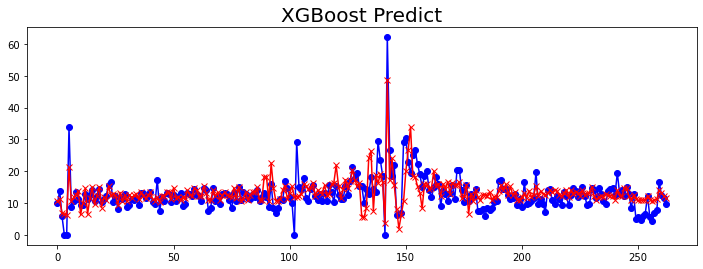

In [25]:
pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)

# visualization
fig = plt.figure(figsize=(12,4))
chart = fig.add_subplot(1,1,1)
y_valid_reset_index = y_valid['전력사용량'].reset_index()['전력사용량']
chart.plot(y_valid_reset_index[:-30], marker="o", color="blue", label="실제값")
chart.plot(pred[:-30], marker="x", color="red", label="예측값")
chart.set_title("XGBoost Predict", size=20)

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

In [26]:
# 전반적으로 과소추정함. 경향은 맞으니 튜닝시 과소추정 해결방법을 생각할 것

In [27]:
y_valid

,전력사용량
1168,9.90000
1169,13.80000
1170,5.80000
1171,0.00000
1172,0.00000
...,...
1456,11.90000
1457,14.90000
1458,16.90000
1459,15.50000


In [28]:
pred

0     10.71917
1     11.16022
2      6.75637
3      6.51901
4      6.35464
        ...   
288   10.20069
289   11.64486
290   12.47988
291   12.26596
292   16.14024
Length: 293, dtype: float32

In [29]:
loss = sum(y_valid_reset_index - pred)
loss

-67.31595182418826